29-197002 経済学研究科D1

奥村恭平

## Problem 1

Below, we derive
\[
    \Pr(d_i = j) = \frac{\exp(\delta_j)}{\sum_{k \in \mathcal{J}} \exp(\delta_k)}
\]

Let $f$ be the pdf of Extreme Value Type I random variable: $f(x) := F'(x) = \mathrm e^{-x} \cdot \exp(-\exp(-x))$.

\begin{align*}
	\Pr(d_i = j)
		&=
			\Pr(\forall k \neq j; \ u_{ij} \geq u_{ik}) \\
		&=
			\Pr(\forall k \neq j; \ \epsilon_{ij} + \delta_j - \delta_k \geq \epsilon_{ik}) \\
		&=
			\prod_{k \neq j} \Pr(\epsilon_{ij} + \delta_j - \delta_k \geq \epsilon_{ik}) \quad (\because \ \text{indep.}) \\
		&=
			\int_{-\infty}^\infty F(\epsilon_{ij} + \delta_j - \delta_k) f(\epsilon_{ij}) \mathrm d \epsilon_{ij} \\
		&=
			\int_{-\infty}^\infty \exp\left(
			\sum_{k \neq j} - \exp(-\epsilon_{ij} - \delta_j + \delta_k)
			\right)
			\mathrm e^{-\epsilon_{ij}} \cdot \exp(-\exp(-\epsilon_{ij}))
			\mathrm d \epsilon_{ij} \\
		&=
			\int_{-\infty}^\infty \exp\left(
				\sum_{k} - \exp(-x - \delta_j + \delta_k)
				\right)
				\mathrm e^{-x}
				\mathrm d x \quad (x := \epsilon_{ij})\\
		&=
			\int_{-\infty}^\infty \exp\left(
			- \mathrm e^{-x}
				\sum_{k} \exp(\delta_k - \delta_j)
				\right)
				\mathrm e^{-x}
				\mathrm d x \\
		&=
			\int_{0}^\infty \exp\left(
			-t
				\sum_{k} \exp(\delta_k - \delta_j)
				\right)
				\mathrm d t \quad (t := \mathrm e^{-x}) \\
		&=
			\left[-
				\left(\sum_{k} \exp(\delta_k - \delta_j)\right)^{-1}
				\exp\left(
				-t
					\sum_{k} \exp(\delta_k - \delta_j)
					\right)
			\right]_{0}^{\infty} \\
		&=
			\left(\sum_{k} \exp(\delta_k - \delta_j)\right)^{-1} \\
		&=
		\frac{\exp(\delta_j)}{\sum_k \exp (\delta_k)}
\end{align*}

## Problem 2

The likelihood is:
\[
    \sum_i \sum_j y_{ij} \cdot \log \left(
        \frac{\exp(X_{ij} \beta)}{1 + \sum_k \exp(X_{ik}\beta)}
    \right)
\]

In order to use `scipy.optimize.minimize`, we define a loss function that is the likelihood multiplied by $-1$.

The estimated value is $\beta^* \approx (-1.88673942, 0.09717683, -1.02683967)$.

In [16]:
# import
import pandas as pd
import numpy as np
from scipy.optimize import minimize


# read csv
df = pd.read_csv('DataPS201901.csv', header=None)
data = df.values

# pre-processing
x = [{'hp': 1.0, 'fe': 5.0}, {'hp': 1.2, 'fe': 3.5}, {'hp': 1.4, 'fe': 2.0}]
y = data[:,0]

age = data[:, 1]
gender = data[:, 2]
N = data.shape[0] # the number of agents
J = data.shape[1] # the number of goods

age = age[:, np.newaxis]/100 # rescaling
gender = gender[:, np.newaxis]

X = []
for j in range(data.shape[1]):
    temp = np.hstack([np.ones((N,1)), age * x[j]['hp'], gender * x[j]['fe']])
    X.append(temp)

    
# loss function
## use numpy to speed up
def loss_np(beta):
    # temp(i,j) = exp(X_ij @ beta)
    for j in range(J):
        if j == 0:
            temp = np.exp(X[j] @ beta)[:, np.newaxis]
        else:
            temp = np.hstack([temp, np.exp(X[j] @ beta)[:, np.newaxis]])

    exp_sum = np.sum(temp, axis=1) + 1

    # z_ij は，(i,j)に対応するlogの中身
    z_0 = np.ones((N,1)) / exp_sum[:, np.newaxis] # outside option
    z = temp / exp_sum[:, np.newaxis]
    z = np.hstack([z_0, z])
    w = np.log(z)
    
    Y = np.zeros((N, J+1))
    for i in range(N):
        Y[i][y[i]] = 1
    
    return - (Y * w).sum()

res = minimize(loss_np, x0=[1, 1, 1])
beta = res.x
beta[1] = beta[1] / 100 # rescaling

print('The estimated beta is {}'.format(beta))

The estimated beta is [-1.88673942  0.09717683 -1.02683967]


### 試行錯誤

* 以下は試行錯誤の記録．
* outside optionの扱い方を微妙に間違えていたので，$\beta_0$の推定値が冒頭のものとずれている．(冒頭のコードでは修正済み)
* 一応記録として残しておく．

In [121]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('DataMat.csv', header=None)
data = df.values

In [45]:
x = [{'hp': 1, 'fe': 5}, {'hp': 1.2, 'fe': 3.5}, {'hp': 1.4, 'fe': 2}]

In [5]:
data[1:4]

array([[ 0, 29,  1],
       [ 1, 27,  0],
       [ 3, 36,  0]])

* outside optionから得る効用はどう考えればよい？
* とりあえず，option 0からのutilityは0と仮定しておく．
    - likelihoodを見た感じこうしていそう．

In [7]:
y = data[:,0]
y.shape

(10000,)

In [29]:
age = data[:, 1]
gender = data[:, 2]
N = data.shape[0] # the number of agents
J = data.shape[1] # the number of goods

In [10]:
age.shape

(10000,)

In [11]:
age[:, np.newaxis].shape

(10000, 1)

In [19]:
age = age[:, np.newaxis]
gender = gender[:, np.newaxis]

In [23]:
X = []
for i in range(data.shape[1]):
    temp = np.hstack([np.ones((n,1)), age * x[i]['hp'], gender * x[i]['fe']])
    X.append(temp)

In [24]:
len(X)

3

In [27]:
X[0].shape

(10000, 3)

In [32]:
X[0][0:3]

array([[ 1., 46.,  5.],
       [ 1., 29.,  5.],
       [ 1., 27.,  0.]])

In [33]:
X[0][0]

array([ 1., 46.,  5.])

The likelihood is:
\[
    \sum_i \sum_j y_{ij} \cdot \log \left(
        \frac{\exp(X_{ij} \beta)}{1 + \sum_k \exp(X_{ik}\beta)}
    \right)
\]

In order to use `scipy.optimize.minimize`, we define a loss function that is the likelihood multiplied by $-1$.

In [39]:
def loss(beta):
    likelihood = 0
    
    for i in range(N):
        exp_sum_i = 0
        for k in range(J):
            exp_sum_i += np.exp(np.dot(X[k][i], beta))
            
        for j in range(J):
            if y[i] == j+1:
                likelihood += np.log(np.exp(np.dot(X[j][i], beta)) / (1 + exp_sum_i))
            
    return -likelihood

In [40]:
minimize(loss, x0=[1,1,1])

      fun: 5642.963877239355
 hess_inv: array([[1.21910144e+03, 1.41089742e-02, 5.41872993e-01],
       [1.41089742e-02, 6.58271907e-06, 2.53141516e-05],
       [5.41872993e-01, 2.53141516e-05, 9.30043903e-04]])
      jac: array([0.        , 0.0090332 , 0.18096924])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 527
      nit: 20
     njev: 103
   status: 2
  success: False
        x: array([13.3987244 ,  0.09608822, -1.02544154])

In [41]:
minimize(loss, x0=[0,0,0])

      fun: 5642.963534304632
 hess_inv: array([[ 8.77955991e-05, -2.45414936e-08, -6.29354103e-06],
       [-2.45414936e-08,  1.31857332e-06,  1.22613938e-06],
       [-6.29354103e-06,  1.22613938e-06,  1.58809846e-06]])
      jac: array([ 0.00000000e+00,  2.44140625e-04, -6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 821
      nit: 14
     njev: 161
   status: 2
  success: False
        x: array([16.87920569,  0.09608177, -1.02567451])

In [44]:
minimize(loss, x0=[0,0,0], method='CG')

     fun: 5642.966086993853
     jac: array([-0.00354004,  0.00561523,  0.0012207 ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 3267
     nit: 213
    njev: 651
  status: 2
 success: False
       x: array([11.35671974,  0.09608279, -1.02566112])

* $\beta_0$の値がまちまち．数値誤差？

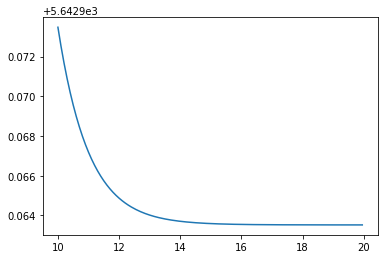

In [59]:
# plotしてみる
beta0s = np.arange(10,20,0.05)
losses = []
for beta0 in beta0s:
    losses.append(loss(np.array([beta0, 0.09608279, -1.02566112])))
losses = np.array(losses)
plt.plot(beta0s, losses)
plt.show()

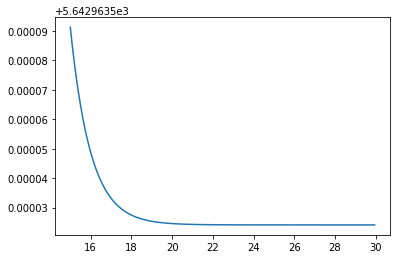

In [60]:
# plotしてみる
beta0s = np.arange(15,30,0.05)
losses = []
for beta0 in beta0s:
    losses.append(loss(np.array([beta0, 0.09608279, -1.02566112])))
losses = np.array(losses)
plt.plot(beta0s, losses)
plt.show()

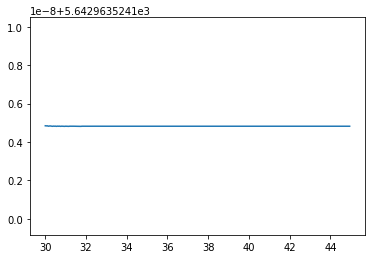

In [61]:
# plotしてみる
beta0s = np.arange(30,45,0.05)
losses = []
for beta0 in beta0s:
    losses.append(loss(np.array([beta0, 0.09608279, -1.02566112])))
losses = np.array(losses)
plt.plot(beta0s, losses)
plt.show()

In [62]:
loss(np.array([0,0,0]))

11901.33709021596

* $\beta_0$は大きければなんでもよい　みたいになっている．おかしい．

### 高速化

* いろいろ試したいが，計算が遅くてイライラする．
    - 一回最適化するのに数分かかる．

* なるべくfor文を避けてnumpyを用いて高速化

In [67]:
beta = np.array([1,1,1])

In [63]:
X[0]

array([[ 1., 46.,  5.],
       [ 1., 29.,  5.],
       [ 1., 27.,  0.],
       ...,
       [ 1., 56.,  0.],
       [ 1., 34.,  0.],
       [ 1., 32.,  5.]])

In [68]:
X[0] @ beta

array([52., 35., 28., ..., 57., 35., 38.])

In [69]:
np.exp(X[0] @ beta) # exp(X_{i1} beta)

array([3.83100800e+22, 1.58601345e+15, 1.44625706e+12, ...,
       5.68572000e+24, 1.58601345e+15, 3.18559318e+16])

In [70]:
np.exp(X[0] @ beta).shape

(10000,)

In [72]:
# temp(i,j) = exp(X_ij @ beta)

for i in range(J):
    if i == 0:
        temp = np.exp(X[i] @ beta)[:, np.newaxis]
    else:
        temp = np.hstack([temp, np.exp(X[i] @ beta)[:, np.newaxis]])
temp.shape

(10000, 3)

In [75]:
np.sum(temp, axis=1).shape

(10000,)

In [77]:
exp_sum = np.sum(temp, axis=1)+1

In [86]:
# z_ij は，(i,j)に対応するlogの中身
z = temp / exp_sum[:, np.newaxis]

In [92]:
w = np.log(z)
w.shape

(10000, 3)

In [95]:
Y = np.zeros((N, J+1))
Y.shape

(10000, 4)

In [96]:
for i in range(N):
    Y[i][y[i]] = 1

In [90]:
Y[0:4]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [91]:
y[0:4]

array([3, 0, 1, 3])

In [97]:
Y = Y[:, 1:]
Y.shape

(10000, 3)

In [99]:
S = Y * w
S.shape

(10000, 3)

In [100]:
S[0:4]

array([[-0.00000000e+00, -0.00000000e+00, -4.52929647e-04],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.08045267e+01, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -7.46864226e-04]])

In [101]:
S.sum()

-22210.342850421337

In [102]:
loss(np.array([1,1,1]))

22210.342850421253

In [80]:
a = np.array([
    [1,2],
    [3,4],
    [5,6]
])
a.shape

(3, 2)

In [81]:
a

array([[1, 2],
       [3, 4],
       [5, 6]])

In [83]:
b = np.array(
    [
        [1],
        [2],
        [3]
    ]
)
b.shape

(3, 1)

In [84]:
a/b

array([[1.        , 2.        ],
       [1.5       , 2.        ],
       [1.66666667, 2.        ]])

In [104]:
def loss_np(beta):
    # temp(i,j) = exp(X_ij @ beta)
    for i in range(J):
        if i == 0:
            temp = np.exp(X[i] @ beta)[:, np.newaxis]
        else:
            temp = np.hstack([temp, np.exp(X[i] @ beta)[:, np.newaxis]])
    
    exp_sum = np.sum(temp, axis=1) + 1
    
    # z_ij は，(i,j)に対応するlogの中身
    z = temp / exp_sum[:, np.newaxis]
    w = np.log(z)
    
    Y = np.zeros((N, J+1))
    for i in range(N):
        Y[i][y[i]] = 1
    Y = Y[:, 1:]
    
    return - (Y * w).sum()

In [105]:
loss_np(np.array([1,1,1]))

22210.342850421337

In [106]:
minimize(loss_np, [1,1,1])

      fun: 5642.963524136284
 hess_inv: array([[5.78318199e+04, 8.06373802e-02, 2.56322866e-03],
       [8.06373802e-02, 5.39552692e-06, 3.96435098e-08],
       [2.56322866e-03, 3.96435098e-08, 1.74628076e-06]])
      jac: array([ 0.00000000e+00, -6.10351562e-05,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 176
      nit: 23
     njev: 35
   status: 2
  success: False
        x: array([21.76523867,  0.0960819 , -1.02567136])

In [108]:
minimize(loss_np, [10,1,1])

      fun: 5642.963534561806
 hess_inv: array([[1.38947970e+04, 2.38641889e-03, 1.27876531e+00],
       [2.38641889e-03, 6.30382152e-06, 3.51841571e-05],
       [1.27876531e+00, 3.51841571e-05, 1.28517903e-03]])
      jac: array([ 0.        , -0.0536499 ,  0.01037598])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 362
      nit: 21
     njev: 70
   status: 2
  success: False
        x: array([16.85951258,  0.09608192, -1.0256601 ])

* 数値誤差の問題は残る

### 数値誤差の影響の緩和

In [109]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt

In [110]:
df = pd.read_csv('DataMat.csv', header=None)
data = df.values

x = [{'hp': 1, 'fe': 5}, {'hp': 1.2, 'fe': 3.5}, {'hp': 1.4, 'fe': 2}]
y = data[:,0]

age = data[:, 1]
gender = data[:, 2]
N = data.shape[0] # the number of agents
J = data.shape[1] # the number of goods

age = age[:, np.newaxis]
gender = gender[:, np.newaxis]

X = []
for i in range(data.shape[1]):
    temp = np.hstack([np.ones((n,1)), age * x[i]['hp'], gender * x[i]['fe']])
    X.append(temp)

In [111]:
def loss_np(beta):
    # temp(i,j) = exp(X_ij @ beta)
    for i in range(J):
        if i == 0:
            temp = np.exp(X[i] @ beta)[:, np.newaxis]
        else:
            temp = np.hstack([temp, np.exp(X[i] @ beta)[:, np.newaxis]])
    
    exp_sum = np.sum(temp, axis=1) + 1
    
    # z_ij は，(i,j)に対応するlogの中身
    z = temp / exp_sum[:, np.newaxis]
    w = np.log(z)
    
    Y = np.zeros((N, J+1))
    for i in range(N):
        Y[i][y[i]] = 1
    Y = Y[:, 1:]
    
    return - (Y * w).sum()

In [112]:
loss_np(np.array([1,1,1]))

22210.342850421337

第二列の数値(age)を小さくしてみてはどうか？

In [116]:
df = pd.read_csv('DataMat.csv', header=None)
data = df.values

x = [{'hp': 1, 'fe': 5}, {'hp': 1.2, 'fe': 3.5}, {'hp': 1.4, 'fe': 2}]
y = data[:,0]

age = data[:, 1]
gender = data[:, 2]
N = data.shape[0] # the number of agents
J = data.shape[1] # the number of goods

age = age[:, np.newaxis]/100
gender = gender[:, np.newaxis]

X = []
for i in range(data.shape[1]):
    temp = np.hstack([np.ones((n,1)), age * x[i]['hp'], gender * x[i]['fe']])
    X.append(temp)

In [118]:
loss_np(np.array([1,1,1]))

16654.455508814288

In [119]:
minimize(loss_np, [1,1,1])

      fun: 5642.963535419735
 hess_inv: array([[ 0.08824049, -0.0512807 , -0.00658171],
       [-0.0512807 ,  0.0610947 ,  0.00335037],
       [-0.00658171,  0.00335037,  0.00125427]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 85
      nit: 11
     njev: 17
   status: 0
  success: True
        x: array([16.77548996,  9.60819282, -1.02567122])

なんか上手くいったっぽい．

$\beta^* = (16.775, 0.096, -1.026)$

In [2]:
# 念の為初期値を変えてみる
minimize(loss_np, [0,0,0])

      fun: 5642.963551863224
 hess_inv: array([[ 1.22333038e+04,  7.74993674e+00, -7.69986433e-01],
       [ 7.74993674e+00,  4.97769923e-02,  1.44737346e-03],
       [-7.69986433e-01,  1.44737346e-03,  9.22784616e-04]])
      jac: array([ 0.        ,  0.00396729, -0.0234375 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 377
      nit: 35
     njev: 73
   status: 2
  success: False
        x: array([15.89925025,  9.60835769, -1.02568734])

In [5]:
# 念の為初期値を変えてみる
minimize(loss_np, [16,9,-1])

      fun: 5642.963548730857
 hess_inv: array([[ 1.38876898, -2.45193404, -0.16530284],
       [-2.45193404,  4.37719587,  0.29321664],
       [-0.16530284,  0.29321664,  0.02071805]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 150
      nit: 7
     njev: 30
   status: 0
  success: True
        x: array([15.99999076,  9.6081896 , -1.02567141])

In [6]:
# 念の為初期値を変えてみる
minimize(loss_np, [18,9,-1])

      fun: 5642.963527397953
 hess_inv: array([[ 1.        , -0.0603509 , -0.01708453],
       [-0.0603509 ,  0.06611195,  0.00476929],
       [-0.01708453,  0.00476929,  0.00160369]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([17.9999953 ,  9.6081883 , -1.02567159])

In [7]:
# 念の為初期値を変えてみる
minimize(loss_np, [20,9,-1])

      fun: 5642.963524510758
 hess_inv: array([[1.00000000e+00, 2.02291122e-05, 1.26669092e-06],
       [2.02291122e-05, 6.20274536e-02, 3.55855362e-03],
       [1.26669092e-06, 3.55855362e-03, 1.24754930e-03]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 35
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([20.00019435,  9.60819234, -1.02567127])

In [3]:
# 念の為初期値を変えてみる
minimize(loss_np, [50,9,-1])

      fun: 5642.963524058943
 hess_inv: array([[ 9.99999999e-01, -4.25113831e-06, -1.92721481e-07],
       [-4.25113831e-06,  2.62783048e-02,  8.39832428e-04],
       [-1.92721481e-07,  8.39832428e-04,  1.14487409e-03]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([49.99990282,  9.6081908 , -1.02567131])

In [10]:
for i in range(J+1):
    print(np.sum(data[:,0]==i))

1415
652
1610
6323
